In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

import seaborn as sns
from ast import literal_eval
from pathlib import Path
from itertools import product
import warnings
#import os
#os.chdir("..")
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (12, 3)

In [27]:
dataset_names = {42900: "Breast Cancer Coimbra",
                 41945: "Indian Liver Patients",
                 "thorax": "Coronary Heart Disease"}

label_mapping={"lookahead":"Lookahead",
            "method":"Method",
            "score_set": "Score Set",
            "calibration_method": "Calibration",
            "('calibration_method', 'isotonic')":"Isotonic Regression",
            "beta":"Beta Calibration",
            "psl_prebin":"Prebinarization",
            "psl":"In-Search Binarization",
            "psl_logreg": "Stagewise Logistic Regression",
            "stage":"Stage",
            "train_ent":"Expected Entropy",
            "clf_variant": "Variant",
            "bisect":"Bisect",
            "brute":"Bruteforce",
            "test_brier" : "Brier Score",
            "('calibration_method', 'beta')":"Beta Calibration",
            "(('calibration_method', 'beta'), 'psl')":"PSL Beta Calibration", 
            "(('calibration_method', 'beta_reg'), 'psl')":"PSL Beta Calibration (regularized)", 
            "(('calibration_method', 'isotonic'), 'psl')":"PSL Isotonic Regression",
            "(('calibration_method', 'sigmoid'), 'psl')":"PSL Sigmoid Regression",
            "(('calibration_method', 'isotonic'), 'psl_logreg')": "Stagewise Logistic Regression",
            "(('calibration_method', 'isotonic'), 'psl_logreg_unregularized')": "Stagewise Logistic Regression (unregularized)",
            "(('calibration_method', 'beta'), 'psl_prebin')":"PSL Beta Calibration", 
            "(('calibration_method', 'beta_reg'), 'psl_prebin')":"PSL Beta Calibration (regularized)", 
            "(('calibration_method', 'isotonic'), 'psl_prebin')":"PSL Isotonic Regression",
            "(('calibration_method', 'sigmoid'), 'psl_prebin')":"PSL Sigmoid Regression",
            "(('calibration_method', 'isotonic'), 'psl_prebin_logreg')": "Stagewise Logistic Regression",
            "(('calibration_method', 'isotonic'), 'psl_prebin_logreg_unregularized')": "Stagewise Logistic Regression (unregularized)",
            "test_roc" : "ROC AUC",
            "train_roc" : "ROC AUC",
            "soft_ranking_loss": "Soft Rank Loss",
            "expected_entropy":"Expected Entropy",
            }

In [28]:
# load all files
df = pd.concat((pd.read_csv(f) for f in Path("results").glob("*.csv") if f.stat().st_size > 0 ), ignore_index=True)
df = df.drop("params",axis=1)
df["test_brier"] = -df["test_brier"]
df["train_brier"] = -df["train_brier"]
# eval columns
struct_cols = ['score_set',"stage_clf_params"]
df[struct_cols] = df[struct_cols].map(literal_eval)

# clean some stuff
df["clf_variant"] = df.clf.str.cat(df.clf_variant, sep="_", na_rep="").str.rstrip("_")
df["stage_loss"] = df["stage_loss"].fillna("expected_entropy")
for ci, sample in product([5, 10, 20, 50, 80, 90, 95, 99], ["train","test"]):
    col = f"{sample}_conservative_wloss{ci}"
    if col in df:
        df[col] = df[col].fillna(df[f'{sample}_wloss'])
display(df)

,dataset,fold,clf,score_set,lookahead,method,stage_clf_params,fit_time,score_time,test_acc,...,test_conservative_wloss80,train_conservative_wloss90,test_conservative_wloss90,train_conservative_wloss95,test_conservative_wloss95,train_conservative_wloss99,test_conservative_wloss99,stage,clf_variant,stage_loss
0,thorax,33,psl_prebin,"(-3, -2, -1, 1, 2, 3)",1,bisect,"(calibration_method, isotonic)",1.619817,0.023004,0.853535,...,0.452020,0.442092,0.452020,0.442092,0.452020,0.442092,0.452020,NaN,psl_prebin,expected_entropy
1,thorax,33,psl_prebin,"(-3, -2, -1, 1, 2, 3)",1,bisect,"(calibration_method, isotonic)",NaN,NaN,0.828283,...,0.828283,0.860523,0.828283,0.860523,0.828283,0.860523,0.828283,0.0,psl_prebin,expected_entropy
2,thorax,33,psl_prebin,"(-3, -2, -1, 1, 2, 3)",1,bisect,"(calibration_method, isotonic)",NaN,NaN,0.828283,...,0.828283,0.860523,0.828283,0.860523,0.828283,0.860523,0.828283,0.0,psl_prebin_logreg,expected_entropy
3,thorax,33,psl_prebin,"(-3, -2, -1, 1, 2, 3)",1,bisect,"(calibration_method, isotonic)",NaN,NaN,0.828283,...,0.828283,0.860523,0.828283,0.860523,0.828283,0.860523,0.828283,0.0,psl_prebin_logreg_unregularized,expected_entropy
4,thorax,33,psl_prebin,"(-3, -2, -1, 1, 2, 3)",1,bisect,"(calibration_method, isotonic)",NaN,NaN,0.828283,...,0.828283,0.860523,0.828283,0.860523,0.828283,0.860523,0.828283,1.0,psl_prebin,expected_entropy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178195,42900,13,psl_prebin,"(-3, -2, -1)",1,bisect,"(calibration_method, isotonic)",NaN,NaN,0.666667,...,0.435897,0.454545,0.435897,0.454545,0.435897,0.454545,0.435897,8.0,psl_prebin_logreg,expected_entropy
178196,42900,13,psl_prebin,"(-3, -2, -1)",1,bisect,"(calibration_method, isotonic)",NaN,NaN,0.564103,...,0.410256,0.311688,0.410256,0.311688,0.410256,0.311688,0.410256,8.0,psl_prebin_logreg_unregularized,expected_entropy
178197,42900,13,psl_prebin,"(-3, -2, -1)",1,bisect,"(calibration_method, isotonic)",NaN,NaN,0.564103,...,0.435897,0.454545,0.435897,0.454545,0.435897,0.454545,0.435897,9.0,psl_prebin,expected_entropy
178198,42900,13,psl_prebin,"(-3, -2, -1)",1,bisect,"(calibration_method, isotonic)",NaN,NaN,0.666667,...,0.435897,0.454545,0.435897,0.454545,0.435897,0.454545,0.435897,9.0,psl_prebin_logreg,expected_entropy


In [29]:
score_set_strings = [str(s) for s in list(df.score_set.unique())]
score_set_latex_labels = [f"$\mathcal{{S}}=\{{{s[1:-1]}\}}$" for s in score_set_strings]

# Here I update the label mapping with the score sets in LaTeX notation
label_mapping.update(dict(zip(score_set_strings,score_set_latex_labels)))

[(('calibration_method', 'isotonic'), 'psl_prebin')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg_unregularized')
 (('calibration_method', 'beta'), 'psl_prebin')]
4400


/tmp/ipykernel_601844/3890944332.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_601844/3890944332.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_601844/3890944332.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_preb

[(('calibration_method', 'beta'), 'psl_prebin')
 (('calibration_method', 'isotonic'), 'psl_prebin')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg_unregularized')]
4000


/tmp/ipykernel_601844/3890944332.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_601844/3890944332.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_601844/3890944332.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_preb

[(('calibration_method', 'beta'), 'psl_prebin')
 (('calibration_method', 'isotonic'), 'psl_prebin')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg_unregularized')]
4400


/tmp/ipykernel_601844/3890944332.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_601844/3890944332.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_601844/3890944332.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_preb

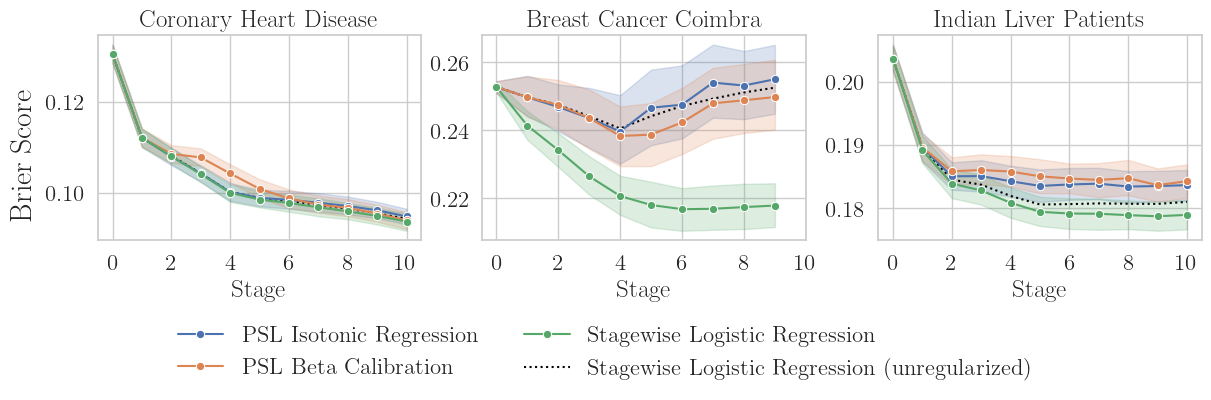

In [30]:
datasets = ["thorax", 42900, 41945]

fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
axes = axes.ravel()
hue_order = [(('calibration_method', 'isotonic'), 'psl_prebin'), (('calibration_method', 'beta'), 'psl_prebin'), (('calibration_method', 'isotonic'), 'psl_prebin_logreg')]


for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3))
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl_prebin", "psl_prebin_logreg", "psl_prebin_logreg_unregularized"]))
    & (df.method.isin(["bisect"]))
    & (~df.stage.isnull())]
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg_unregularized") & (df_.stage_clf_params==('calibration_method', 'beta'))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.stage_clf_params==('calibration_method', 'beta'))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_prebin_logreg_unregularized") & (df_.stage_clf_params==('calibration_method', 'beta'))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_prebin_logreg") & (df_.stage_clf_params==('calibration_method', 'beta'))].index)
    df_ = df_.drop(df_[(df_.stage_clf_params==('calibration_method', 'beta_reg'))].index)
    df_ = df_.drop(df_[(df_.stage_clf_params==('calibration_method', 'sigmoid'))].index)
    print(df_[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1).unique())
    if True or dataset==42900:
        sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
    print(len(df_))
    sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin", "psl_prebin_logreg"])], x="stage", y="test_brier", hue=df_[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1), hue_order=hue_order, marker="o", ax=ax)
    if index == 1:
        handles, labels = np.array(ax.get_legend_handles_labels())[:,[1,2,3,0]]
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

syl = fig.supylabel("Brier Score")
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/brier.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

stage_loss
expected_entropy    4000
Name: count, dtype: int64
stage_loss
expected_entropy    4400
Name: count, dtype: int64


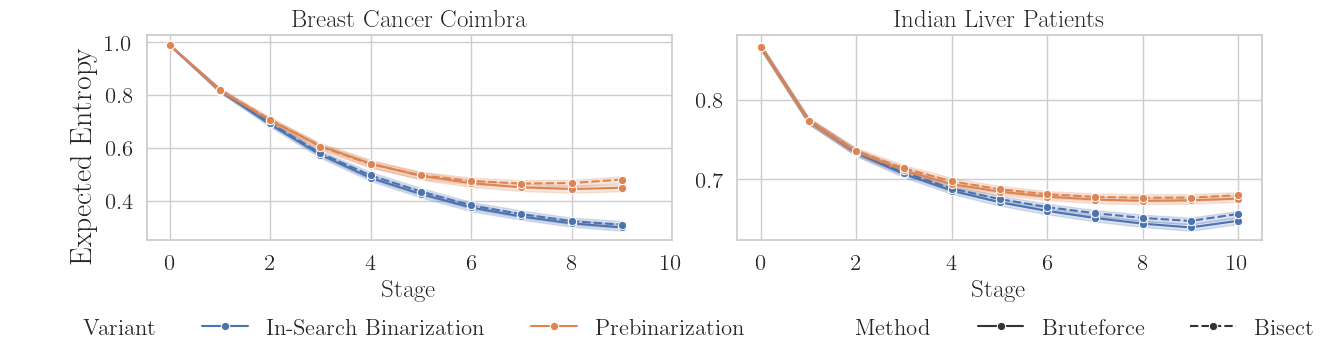

In [31]:
datasets = [42900, 41945]

fig,axes = plt.subplots(1,len(datasets), layout="constrained")
axes = axes.ravel()

hue_order = ["psl", "psl_prebin"]
style_order = ["brute", "bisect"]

for index, dataset in enumerate(datasets):
    ax=axes[index]
    df_ = df[
    (df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3)) 
    & (df.lookahead.isin({None,1})) 
    & (df.clf_variant.isin(["psl","psl_prebin"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss=="expected_entropy")]    
    print(df_["stage_loss"].value_counts())
    sns.lineplot(data=df_, x="stage", y="train_ent", hue="clf_variant", style="method", hue_order=hue_order, style_order=style_order, marker="o", ax=ax)
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Expected Entropy")
handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.18), frameon=False)
plt.savefig("fig/binarization.pdf", bbox_extra_artists=(lgd,syl), bbox_inches="tight")

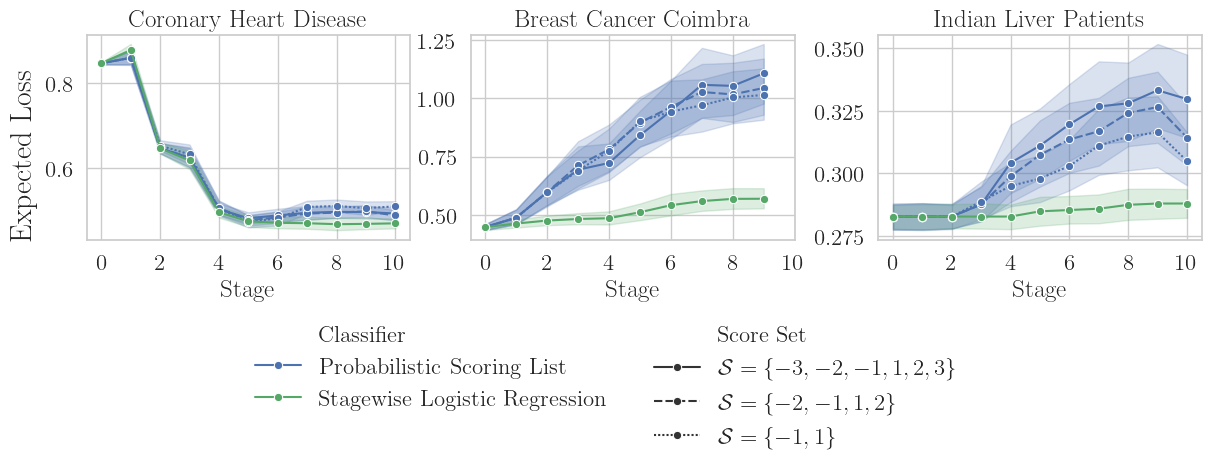

In [32]:
datasets = ["thorax", 42900, 41945]

fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
axes = axes.ravel()

hue_order = ["psl", "", "psl_logreg"]
style_order = [(-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]

for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl", "psl_logreg"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss=="expected_entropy")]
    
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    sns.lineplot(data=df_, x="stage", y="test_wloss", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax)
    #print(len(df_))
    #print(df_.score_set.value_counts())
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Expected Loss")
label_mapping["psl"] = "Probabilistic Scoring List"
label_mapping["clf_variant"] = "Classifier"

handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
handles.insert(3,proxy)
labels.insert(3," ")
lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/expected_loss.pdf", bbox_inches='tight')

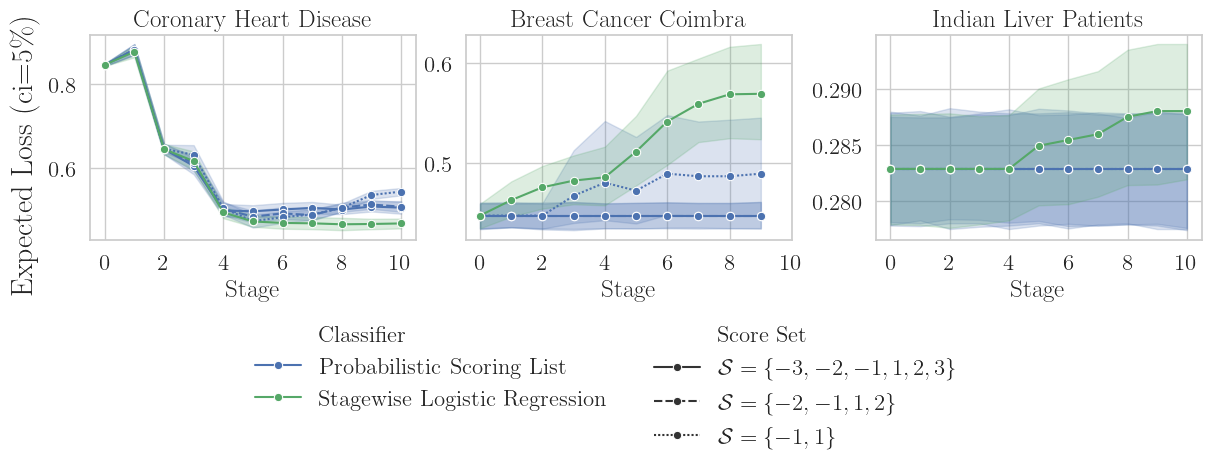

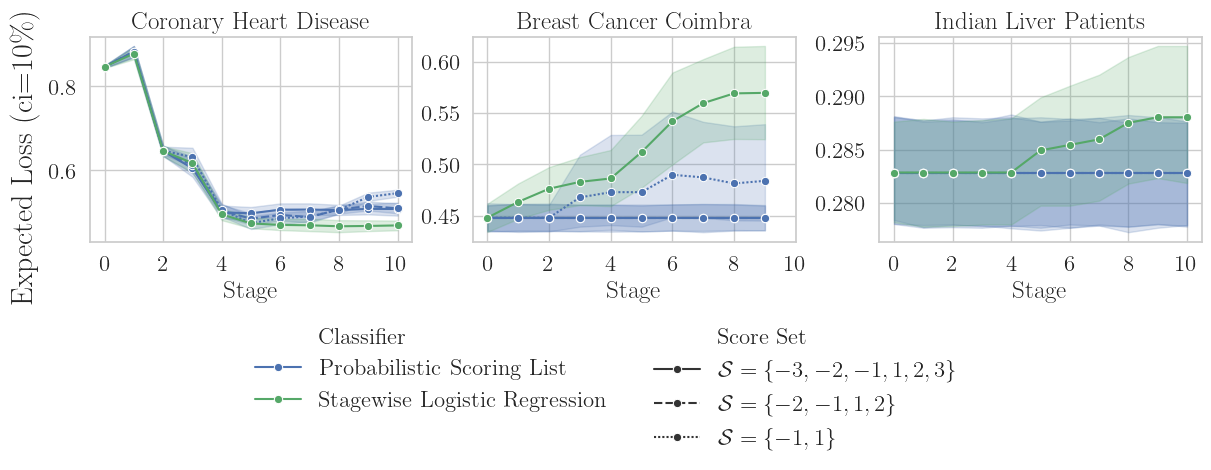

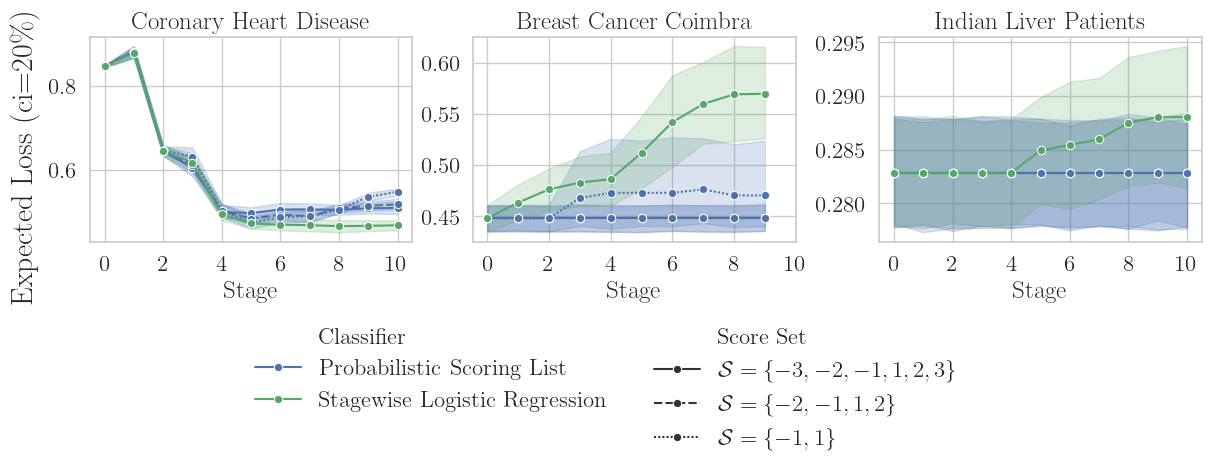

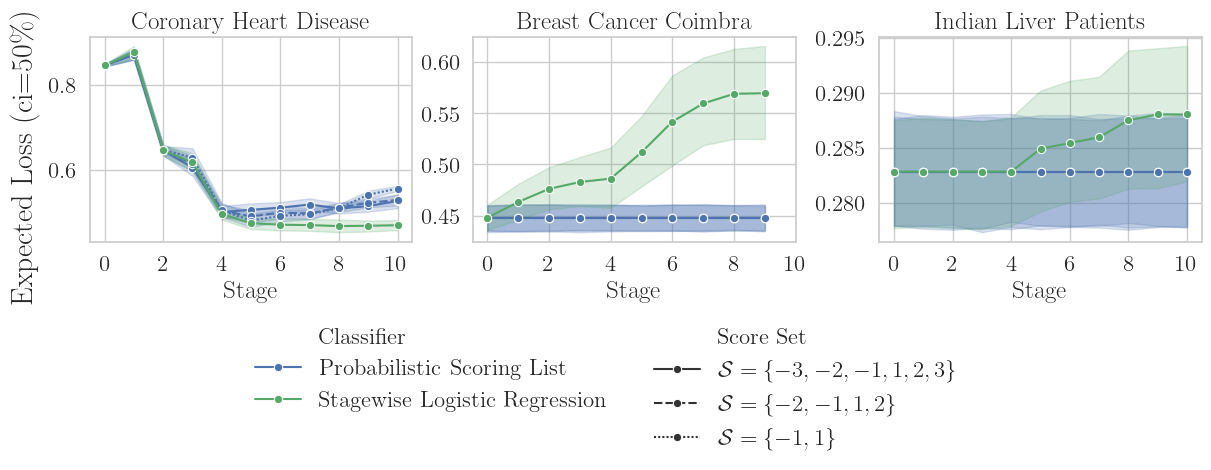

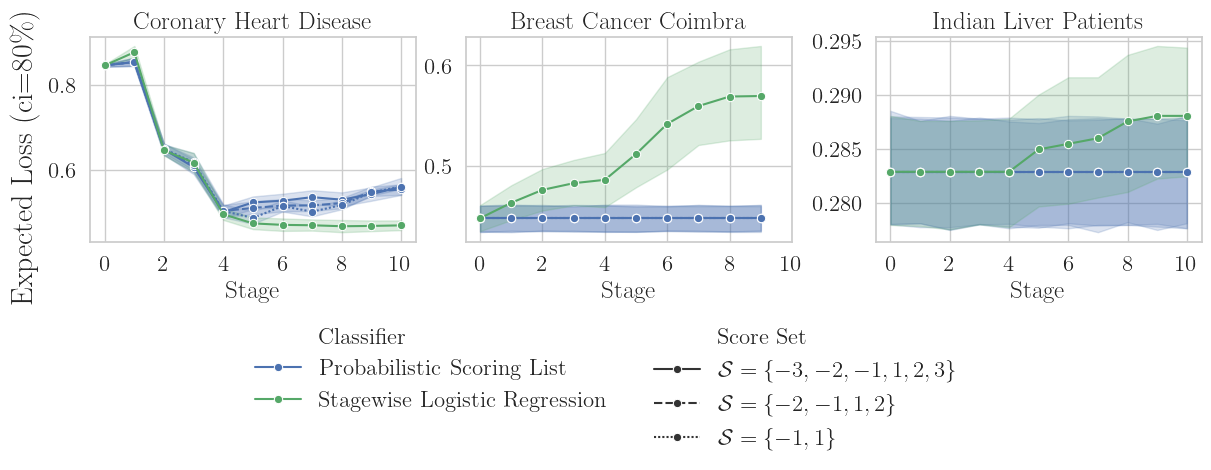

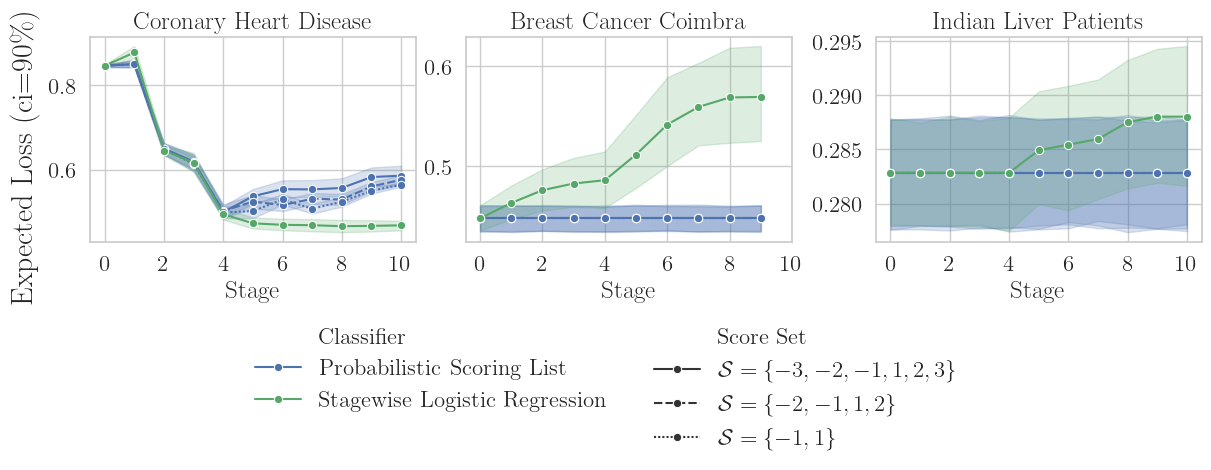

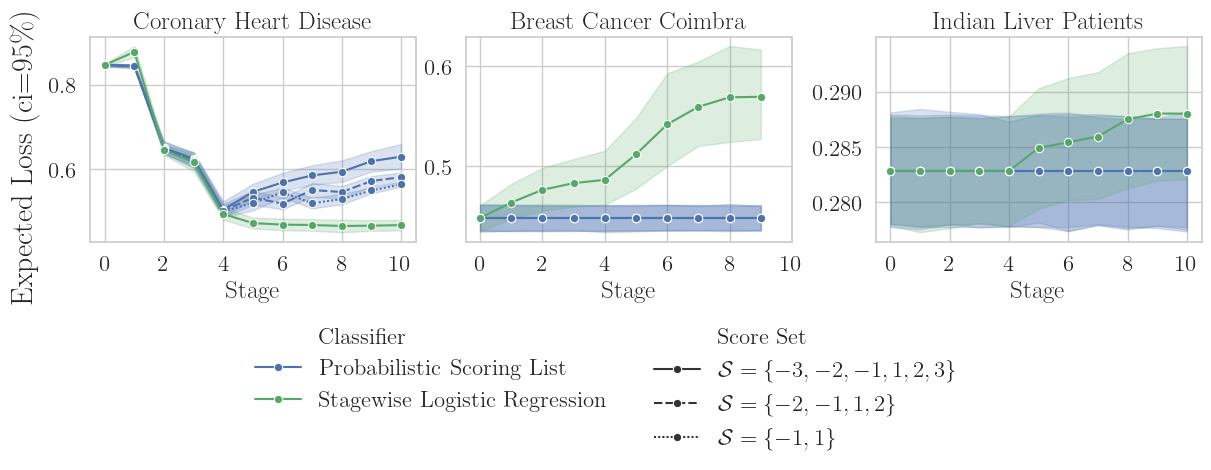

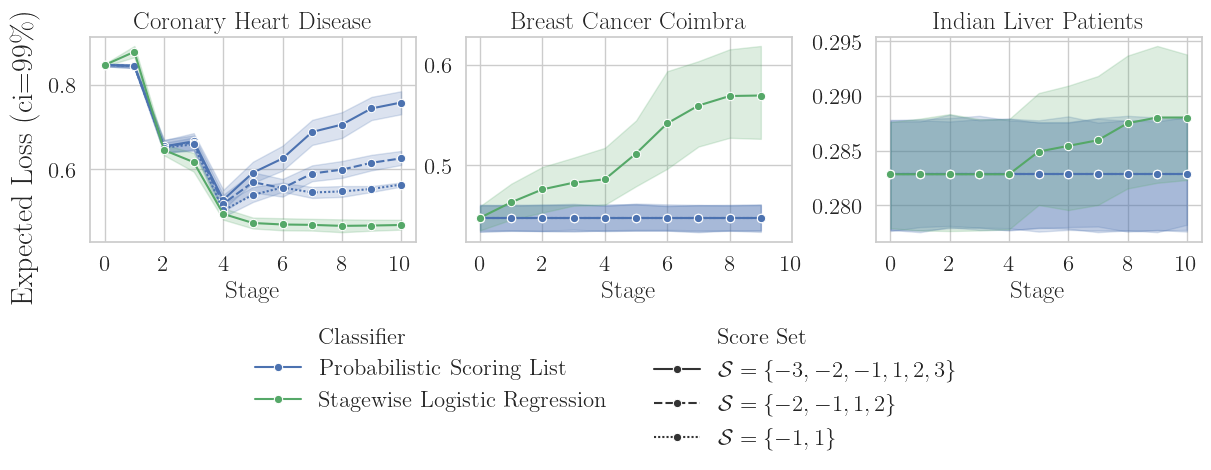

In [33]:
datasets = ["thorax", 42900, 41945]

for ci in [5, 10, 20, 50, 80, 90, 95, 99]:
    fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
    axes = axes.ravel()

    hue_order = ["psl", "", "psl_logreg"]
    style_order = [(-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]


    for index, dataset in enumerate(datasets):
        ax=axes[index]

        df_ = df[(df.dataset == datasets[index])
        & (df.lookahead.isin({None,1}))
        & (df.clf_variant.isin(["psl", "psl_logreg"]))
        & (df.method.isin(["bisect"]))
        & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
        & (~df.stage.isnull())
        & (df.stage_loss=="expected_entropy")]
        
        df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
        sns.lineplot(data=df_, x="stage", y=f"test_conservative_wloss{ci}", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax)
        #print(len(df_))
        #print(df_.score_set.value_counts())
        ax.get_legend().remove()
        ax.set_title(dataset_names[dataset])
        ax.set_ylabel(None)
        ax.set_xlabel("Stage")
        ax.set_xticks(list(range(0,11)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    syl = fig.supylabel(f"Expected Loss")
    label_mapping["psl"] = "Probabilistic Scoring List"
    label_mapping["clf_variant"] = "Classifier"

    handles, labels = ax.get_legend_handles_labels()
    labels = [label_mapping[label] for label in labels]
    proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
    handles.insert(3,proxy)
    labels.insert(3," ")
    lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
    plt.savefig(f"fig/expected_loss_{ci}ci.pdf", bbox_inches='tight')

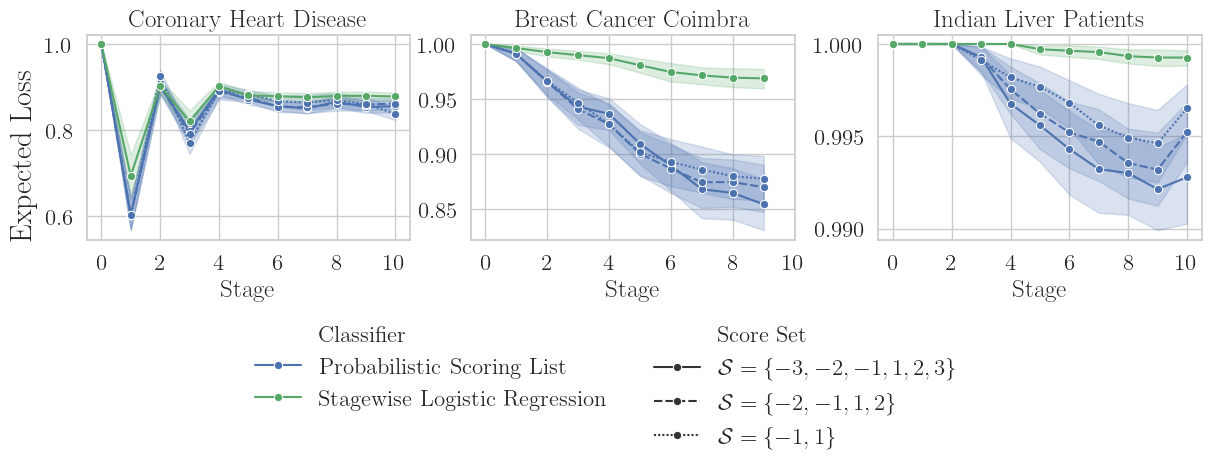

In [34]:
datasets = ["thorax", 42900, 41945]

fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
axes = axes.ravel()

hue_order = ["psl", "", "psl_logreg"]
style_order = [(-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]

for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl", "psl_logreg"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss=="expected_entropy")]
    
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    sns.lineplot(data=df_, x="stage", y="test_recall_at_wloss", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax)
    #print(len(df_))
    #print(df_.score_set.value_counts())
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Expected Loss")
label_mapping["psl"] = "Probabilistic Scoring List"
label_mapping["clf_variant"] = "Classifier"

handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
handles.insert(3,proxy)
labels.insert(3," ")
lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/recall_at_expected_loss.pdf", bbox_inches='tight')

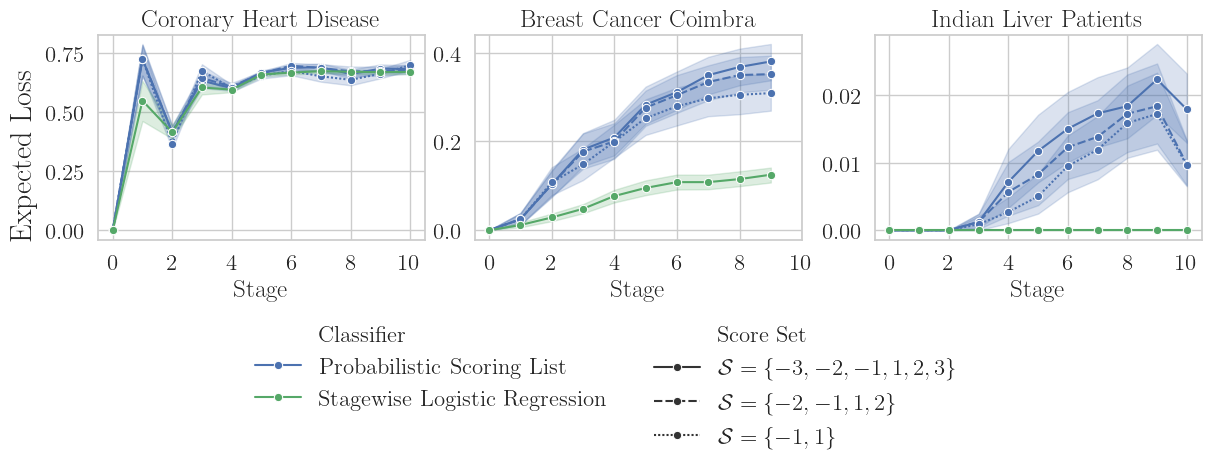

In [35]:
datasets = ["thorax", 42900, 41945]

fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
axes = axes.ravel()

hue_order = ["psl", "", "psl_logreg"]
style_order = [(-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]

for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl", "psl_logreg"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss=="expected_entropy")]

    
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    #df_.test_spec_at_wloss  = 1- df_.test_spec_at_wloss
    sns.lineplot(data=df_, x="stage", y="test_spec_at_wloss", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax)
    #print(len(df_))
    #print(df_.score_set.value_counts())
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Expected Loss")
label_mapping["psl"] = "Probabilistic Scoring List"
label_mapping["clf_variant"] = "Classifier"

handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
handles.insert(3,proxy)
labels.insert(3," ")
lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/recall_at_expected_loss.pdf", bbox_inches='tight')

stage_loss
expected_entropy     1100
soft_ranking_loss    1100
Name: count, dtype: int64
stage_loss
soft_ranking_loss    1000
expected_entropy     1000
Name: count, dtype: int64
stage_loss
expected_entropy     1100
soft_ranking_loss    1100
Name: count, dtype: int64


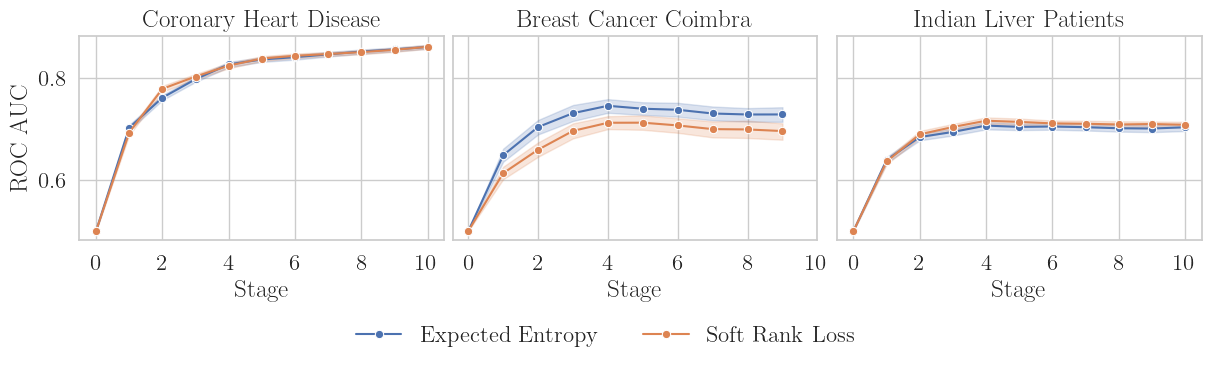

In [36]:
datasets = ["thorax", 42900, 41945]

fig,axes = plt.subplots(1,len(datasets), sharey=True, layout="constrained")
axes = axes.ravel()
hue_order = ["expected_entropy","soft_ranking_loss"]
for index, dataset in enumerate(datasets):
    ax=axes[index]
    df["stage_loss"] = df["stage_loss"].fillna("expected_entropy")
    df_ = df[
    (df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3)) 
    & (df.lookahead.isin({None,1})) 
    & (df.clf_variant.isin(["psl"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())]
    # & (df.stage_loss.isin([None, "soft_rank_loss"]))]
    print(df_.stage_loss.value_counts())
    sns.lineplot(data=df_, x="stage", y="test_roc", hue="stage_loss", marker="o", ax=ax)
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(label_mapping["test_roc"])
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/roc_auc.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')